In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

Sat Jun 12 20:35:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=512):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "image/image") + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask

    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 128
train_path = "/content/drive/MyDrive/dataset/"
epochs = 1
batch_size = 16

## Training Ids
train_ids_x = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 200
test_data_size = 200

valid_ids = train_ids_x[:val_data_size]
test_ids = train_ids_x[val_data_size:val_data_size+test_data_size]
train_ids = train_ids_x[val_data_size+test_data_size:]



In [ ]:
len(train_ids)


1823

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)


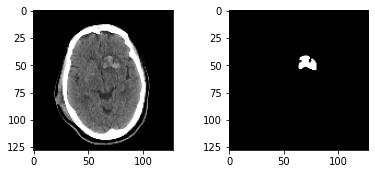

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256,512,1024]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.8
)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
test_gen = DataGen(test_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

#model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    #epochs=25)

In [ ]:
test_image = []
test_mask = []
for i in range(val_data_size,val_data_size + test_data_size):
  a,b = test_gen.__load__(train_ids_x[i])
  test_image.append(a)
  test_mask.append(b)
  print(i)

test_image = np.array(test_image)
test_mask = np.array(test_mask)
test_mask = test_mask*255
for k in range(test_mask.shape[0]):
  for i in range(test_mask.shape[1]):
    for j in range(test_mask.shape[2]):
      if(test_mask[k][i][j] > 0):
        test_mask[k][i][j] = 255

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/model18.h5")


In [ ]:
#for z in range(20,40):
  #model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                      #epochs=25)
result = model.predict(test_image)
result = result > 0.2
result = result*255

total_union = 0
total_intersection = 0

percentages = []

for k in range(test_mask.shape[0]):
  union = 0
 intersection = 0
  for i in range(test_mask.shape[1]):
    for j in range(test_mask.shape[2]):
      if(test_mask[k][i][j] == 255):
        if(result[k][i][j] == 255):
          total_union +=1
          total_intersection +=1
          union+=1
          intersection+=1
        else:
          total_union +=1
          union+=1
      elif(result[k][i][j] == 255):
        total_union += 1
        union+=1
  percentages.append(intersection/union*100)

percentage_total = 0  
for i in range(len(percentages)):
  percentage_total += percentages[i]

print("Iterative = " + str(total_intersection/total_union*100))
print("Cumulative = " + str(percentage_total/len(percentages)))

#model.save("/content/drive/MyDrive/model" + str(z) +".h5")

Genel oran = 51.74580311910202
Teker teker oran = 46.53661268499714


420598
45445


In [ ]:
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=100)

In [ ]:

## Save the Weights
model.save_weights("/content/drive/MyDrive/UNetWBest.h5")



NameError: ignored

In [ ]:


## Dataset for prediction
x, y = test_gen.__getitem__(5)
result = model.predict(x)

result = result > 0.1

In [ ]:
train_ids[0]



'15267'

In [ ]:
a , b = test_gen.__load__(train_ids_x[val_data_size+12])
a = np.resize(a,(1,512,512,3))
b = np.resize(b,(1,522,512))
result = model.predict(a)

#result = result > 0.05


In [ ]:
result.shape
k = 0
maks = 0.1
for i in range(128):
  for j in range(128):
    if(result[0][i][j][0] > maks):
      print(result[0][i][j][0])
      k +=1
print(k)

0


In [ ]:
a , b = test_gen.__load__(train_ids_x[val_data_size+13])
a = np.resize(a,(1,512,512,3))
b = np.resize(b,(1,512,512))
result = model.predict(a)

result = result > 0.05

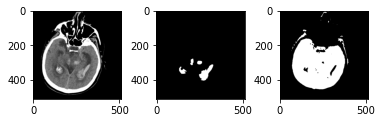

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(a, (image_size, image_size,3)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(b, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result, (image_size, image_size)), cmap="gray")

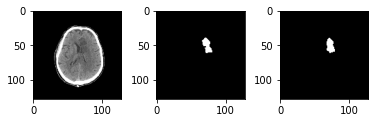

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(x[1], (image_size, image_size,3)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [ ]:
result[0]